In [252]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

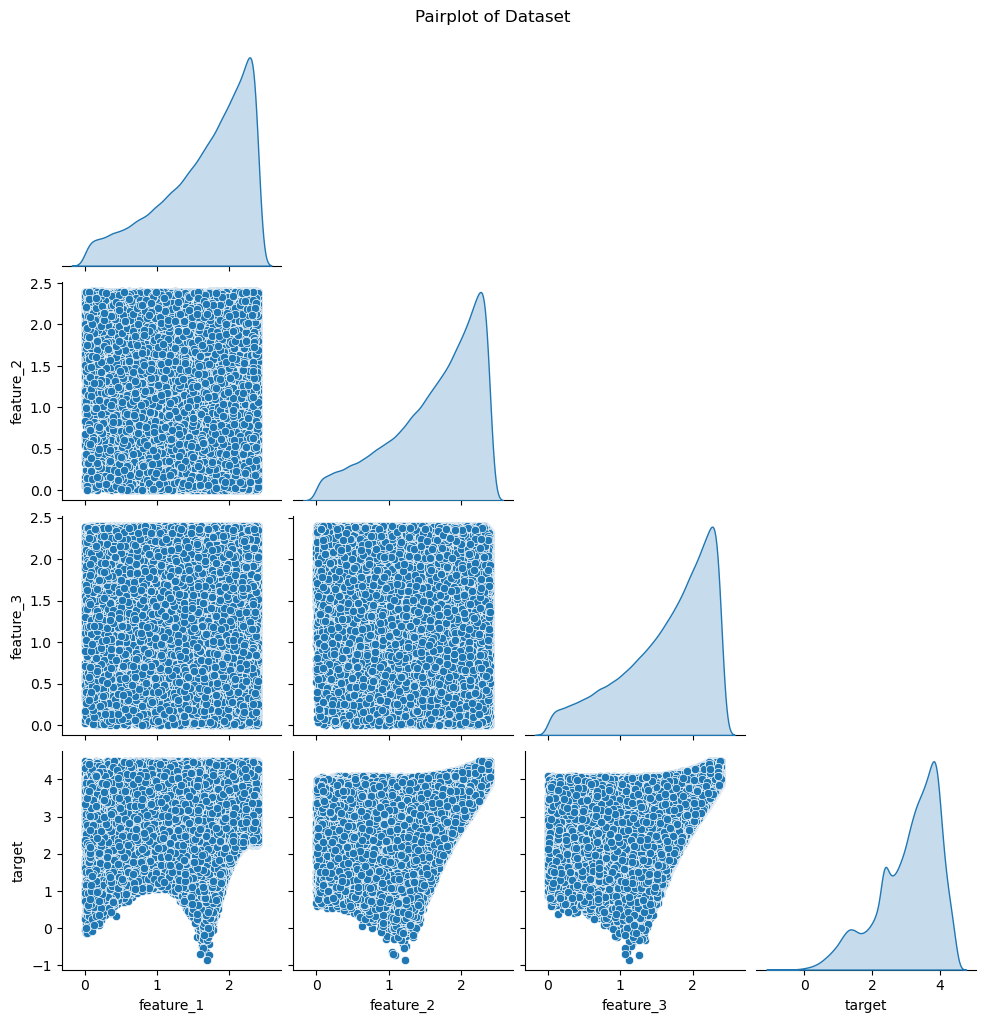

In [253]:
# Завантаження датасету

data = pd.read_csv('dataset_11.csv')

# Функція для виявлення викидів
def detect_outliers_iqr(df):
    outliers = {}
    for column in df.columns:
        if df[column].dtype in [int, float]:  # Перевірка, чи є ознака числовою
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    return outliers

# Виявлення викидів
outliers = detect_outliers_iqr(data)

# Видалення викидів з набору даних
for column in outliers.keys():
    data_cleaned = data[~data.index.isin(outliers[column].index)]

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Логарифмічна трансформація
data_log_transformed = np.log1p(data_cleaned)  # Використовуємо log1p для уникнення проблем з нулями

# Перетворимо знову в DataFrame для зручності
data_log_transformed_df = pd.DataFrame(data_log_transformed, columns=data.columns)

import seaborn as sns

# Візуалізація за допомогою парних діаграм
sns.pairplot(data_log_transformed_df, diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Dataset', y=1.02)
plt.show()

# Припустимо, що перші три колонки — це вхідні параметри, а четверта — результат
X = data.iloc[:, :3].values
y = data.iloc[:, 3].values

# Поділ на навчальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизація даних
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Перетворення даних у тензори
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)



In [254]:
def create_model(input_size, hidden_layers, activation_fn):
    layers = []
    current_input_size = input_size
    
    # Додавання прихованих шарів
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(current_input_size, hidden_size))
        layers.append(activation_fn)
        current_input_size = hidden_size
    
    # Вихідний шар
    layers.append(nn.Linear(current_input_size, 1))
    
    # Побудова моделі
    model = nn.Sequential(*layers)
    return model


In [255]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, lr, epochs=100):
    # Визначаємо оптимізатор та функцію втрат
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Тренування моделі
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        
        # Виводимо результати для кожної епохи
        if (epoch+1) % 100 == 0 or epoch == epochs-1:  # Виводити кожні 100 епох або на останній епосі
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    
    # Оцінка на тестовому наборі
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output, y_test).item()
    
    return test_loss


In [256]:
# Гіперпараметри для експерименту
hidden_layers_options = [64, 32, 16]

activation_fns = nn.SELU()
learning_rates = 0.1
epochs = 2000

# Створимо DataFrame для збору результатів
results = pd.DataFrame(columns=['hidden_layers', 'activation_fn', 'learning_rate', 'test_loss'])

model = create_model(input_size=3, hidden_layers=hidden_layers_options, activation_fn=activation_fns)
test_loss = train_and_evaluate_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, learning_rates, epochs)
# Створюємо тимчасовий DataFrame для поточного результату
result = pd.DataFrame([{
    'hidden_layers': hidden_layers_options,
    'activation_fn': activation_fns.__class__.__name__,
    'learning_rate': learning_rates,
    'test_loss': test_loss
}])
            
# Додаємо результат до DataFrame через pd.concat()
results = pd.concat([results, result], ignore_index=True)


Epoch [100/2000], Loss: 1.666646
Epoch [200/2000], Loss: 0.526324
Epoch [300/2000], Loss: 0.702425
Epoch [400/2000], Loss: 0.328913
Epoch [500/2000], Loss: 0.235874
Epoch [600/2000], Loss: 0.237266
Epoch [700/2000], Loss: 1.869035
Epoch [800/2000], Loss: 0.152939
Epoch [900/2000], Loss: 0.161018
Epoch [1000/2000], Loss: 0.817564
Epoch [1100/2000], Loss: 0.909825
Epoch [1200/2000], Loss: 0.104331
Epoch [1300/2000], Loss: 1.776474
Epoch [1400/2000], Loss: 0.090789
Epoch [1500/2000], Loss: 1.423381
Epoch [1600/2000], Loss: 0.506111
Epoch [1700/2000], Loss: 0.091226
Epoch [1800/2000], Loss: 0.154794
Epoch [1900/2000], Loss: 0.240005
Epoch [2000/2000], Loss: 0.176753


C:\Users\user\AppData\Local\Temp\ipykernel_940\1784651893.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)


In [257]:
# Вивести результати
print(results)

# Сортувати за мінімальною помилкою
optimal_result = results.loc[results['test_loss'].idxmin()]
print("Найкраща конфігурація моделі:")
print(optimal_result)


  hidden_layers activation_fn  learning_rate  test_loss
0  [64, 32, 16]          SELU            0.1   0.177949
Найкраща конфігурація моделі:
hidden_layers    [64, 32, 16]
activation_fn            SELU
learning_rate             0.1
test_loss            0.177949
Name: 0, dtype: object
